Kimberly Devi Milner

EE Independent Study w/  Fraida Fund

# Radio Machine Learning: Modeling the presence of a primary user as a  classification problem


# Theretical Background
**ATTRIBUTION:** Images and references from https://ctvrie.files.wordpress.com/2013/07/cograd_commtheory_2013.pdf

### What is a cognitive radio?
A cognitive radio is a radio that is aware of its environemnt. 

Cognitive radios (CR) can dynamically and autonomously adjust radio parameters to interact with the environment around it. In this way CRs can decide the optimal carrier frequency and bandwidth to guide the signal to its end to end communication. 

### Why do we need cognitive radios?
CISCO foresees a x1000 increase in wireless traffic by 2020. The licensed and unlicensed spectrum cannot grow at this rate. 

Cognitive radios provide several solutions to this dilemma; one including a mechanism to take advantage of spectrum holes -- a point in frequency, time or space -- which is not occupied by any transmission. 

### How  could Cognitive Radios work?

#### Spectrum Awareness
The cognitive/secondary radio can learn about its environment by observing characteristics of the primary uers's channel. These characteristics include:
    * Traffic Patterns
    * Signaling Procedures
    * Channel Conditions
    * (parts of) messages sent by the legacy system


#### Transmitting the Secondary Signal

There are 3 protocols for the secondary user to transmit signals, which break down into "margin" operations and "help" operations.


###### Image References
> * P/STX = primary/secondary transmitter
> * P/SRX = primary/secondary receiver

$$MARGIN:$$
** Underlaying: ** The secondary user's interference to the licensed user's is not avoided, but controlled. The secondary user's intereference should go below the noise floor.
> The difficulty here is due to the fact that the exact interference situation at the primary receiver is not known.

<img src="interweave_2.png">  

** Interleaving: ** Interference by the secondary user is avoided and the secondary user seeks  opportunistic/orthogonal transmission through spectrum holes.
<img src="underlay.png">

$$HELP:$$
** Overlaying: ** The Cognitive Radio knows much more about the primary system (like what message it is sending) and can possibly retransmit this message. 
<img src="overlay.png"> 




# How can we effectively detect whether or not there is another user present on the spectrum that we want to use?

**REFERENCES:** (chapter 2 of Cognitive Radio Book)

*Biglieri, E., Goldsmith, A.J., Greenstein, L.J., Mandayam, N.B. and Poor, H.V. (2012) ‘Capacity of cognitive radio networks’, in Principles of Cognitive Radio:. Cambridge: Cambridge University Press, pp. 41–101.*


## What is  energy sensing 

**Energy sensing**  tries to determine the presence of a spectrum hole by comparing the measured energy of the primary channel against a threshold set for primary-user-presence.

The primary-user-presence "threshold depends on the observed-signal model and hence on the noise variance" (157).
So an error made in the estimation of the noise variance will degrade the performance of an engergy detector.

But as the energy detector cannot discriminate between signal and noise, it is more likely to make errors in estimating noise variance, especially at low SNRs, and perform worse.
 
## What is Signal-to-Noise Ratio (SNR),  also known as channel gain?
$$SNR= \frac{signalPower}{noisePower}$$ 


Channel gain is the amplification or attenuation of a signal on a channel:

Channel gain(H) for channel(S,R)  is: $$Y = HX + Z(noise),$$ where Y is the  signal received.


# An Experiment in SVM classifier

### (to come) Theory behind Q-PSK and constellation
### (to come) Formula forAvg Power
 
> Some Notes

>*Explanation of Experiment to come*

>    Reading; seems relevant to what Fraida  was talking about; useful for writing "Q-PSK" theory section; avg energy theory; 
    http://web.stanford.edu/group/cioffi/doc/book/chap1.pdf
    
>    Will clean up "Generate Qpsk samples" code later

>   Just want to get working classifier

> Nxt part of expr will deal with using better data to make classifier better -- the non-random characteristics

In [11]:
%matplotlib inline
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np


# Generate Q-PSK samples

The signal power is  0.747335504435
The noise power is  0.244525440785
The SNR is 3.05626891842


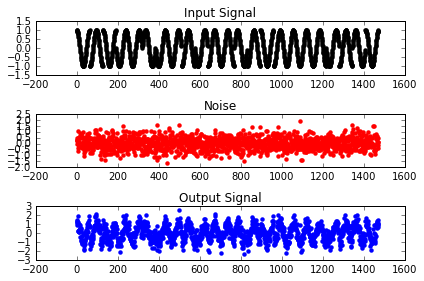

In [127]:
import numpy as np

# PSKModem lifted from CommPy:
# https://github.com/veeresht/CommPy/blob/master/commpy/modulation.py#L97

txpower = 1
freq = 1
m = 4
num_bits_symbol = int(np.log2(m))
symbol_mapping = np.arange(m)
def psk_constellation_symbol(i):
    return np.cos(2*np.pi*(i-1)/m) + np.sin(2*np.pi*(i-1)/m)*(0+1j)

constellation = [psk_constellation_symbol(sym) for sym in symbol_mapping]

samples_per_symbol=64

samples=2*np.pi*np.arange(samples_per_symbol)/samples_per_symbol

nbits = 23 # *samples/sym elements in final array

bitstream = np.random.randint(0,4,nbits)
    #print(constellation)

sstream = []
for bit in bitstream:
    symbol = constellation[bit]
    magnitude = np.abs(symbol)
    phase = np.angle(symbol)
    sstream.append(magnitude*np.sin(samples*freq + phase))
    
x = np.arange(nbits*samples_per_symbol)

input_signal = txpower*np.ndarray.flatten(np.array(sstream))


# AWGN channel also lifted from CommPy
# https://github.com/veeresht/CommPy/blob/master/commpy/channels.py#L72
snr_dB = 3
avg_energy = sum(np.abs(input_signal) * np.abs(input_signal))/len(input_signal)
snr_linear = 10**(snr_dB/10.0)
noise_variance = avg_energy/(2*snr_linear)   
# http://www.rapidtables.com/electric/decibel.htm#power_db
# Notice that amplitude ration is different from power ratio by a factor of 2
#noise_variance = avg_energy/(snr_linear)

if input_signal.dtype == complex:
    noise = (np.sqrt(noise_variance) * np.random.randn(len(input_signal)))  \
    + (np.sqrt(noise_variance) * np.random.randn(len(input_signal))*1j)
else:
    noise = np.sqrt(2*noise_variance) * np.random.randn(len(input_signal))

output_signal = input_signal + noise

# Power of signal and Power of Noise
signal_P = sum([ np.abs(i**2) for i in output_signal])/len(output_signal)
noise_P = sum([ np.abs(i**2) for i in noise]) / len(noise)
print("The signal power is ", signal_P)
print("The noise power is ", noise_P)
print("The SNR is" ,signal_P/noise_P)

plt.subplot(311)
plt.scatter(x,input_signal, color='k',linewidth=".001")
plt.title("Input Signal")
plt.tight_layout()

plt.subplot(312)
plt.scatter(x,noise, color='r',linewidth=".001")
plt.title("Noise")
plt.tight_layout()

plt.subplot(313)
plt.scatter(x,output_signal, color='b',linewidth=".001")
plt.title("Output Signal")
plt.tight_layout()



In [128]:
# Function returns signal and noise power for a hardcoded signal with random bitstream

def gen_sP_nP(snr_dB):  
# AWGN channel also lifted from CommPy
# https://github.com/veeresht/CommPy/blob/master/commpy/channels.py#L72
    #snr_dB = 3
    avg_energy = sum(np.abs(input_signal) * np.abs(input_signal))/len(input_signal)
    snr_linear = 10**(snr_dB/10.0)
    noise_variance = avg_energy/(2*snr_linear)

    if input_signal.dtype == complex:
        noise = (np.sqrt(noise_variance) * np.random.randn(len(input_signal)))  \
        + (np.sqrt(noise_variance) * np.random.randn(len(input_signal))*1j)
    else:
        noise = np.sqrt(2*noise_variance) * np.random.randn(len(input_signal))

    output_signal = input_signal + noise

# Power of signal and Power of Noise
    signal_P = sum([ np.abs(i**2) for i in output_signal])/len(output_signal)
    noise_P = sum([ np.abs(i**2) for i in noise]) / len(noise)
    return  signal_P, noise_P


## SNR of test case 1 is 3dB

(0, 10)

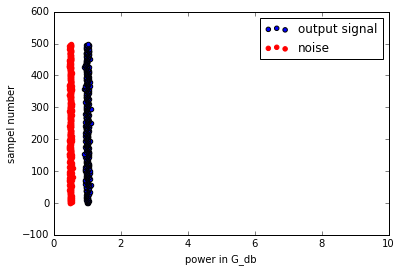

In [129]:
def synth_sP_nP(snr,no_inter):
    signal_P_arr = []
    noise_P_arr = []
    for i in range(1,no_inter): 
        signal_P, noise_P = gen_PSK_samp(snr)
        signal_P_arr.append(signal_P)
        noise_P_arr.append(noise_P)
    return signal_P_arr, noise_P_arr

snr_s_3,  snr_n_3 = synth_sP_nP(3,500)

def plot_snr_syn(snr_s_3,snr_n_3):
    plt.scatter(snr_s_3,range(len(snr_s_3)))
    plt.scatter(snr_n_3,range(len(snr_s_3)), color="r")

    plt.xlabel("power in G_db")
    plt.ylabel("sample number")

    plt.legend(['output signal','noise'],  loc="upper right")

plot_snr_syn(snr_s_3, snr_n_3)
plt.xlim(0,10)


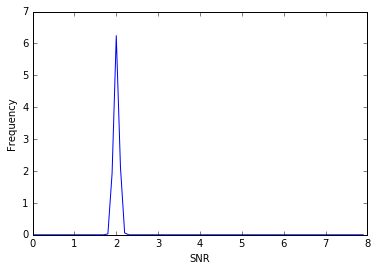

In [138]:
# Plot frequncy 
_= np.array([snr_s_3])
_2 = np.array([snr_n_3])

from scipy import stats
density = stats.kde.gaussian_kde(_/_2)
x = np.arange(0., 8, .1)
plt.plot(x, density(x))
plt.xlabel("SNR")
plt.ylabel("Frequency")

#plt.hist((_/_2).T, bins=6)

# Try to understand how KDE normalized freq


## SNR of test case 2 is 0dB 

(0, 10)

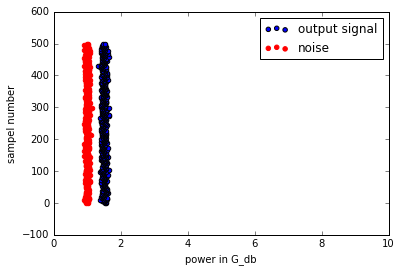

In [131]:
snr_s_10,  snr_n_10 = plt_snr(0,500)
plot_snr_syn(snr_s_10, snr_n_10)
plt.xlim(0,10)

## SNR of test case 2 is -3dB 

(0, 10)

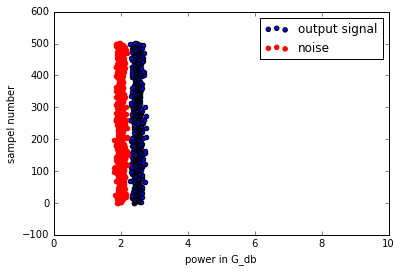

In [121]:
snr_s_10,  snr_n_10 = plt_snr(-3,500)
plot_snr_syn(snr_s_10, snr_n_10)
plt.xlim(0,10)

## SNR of test case 2 is -5dB 

(0, 10)

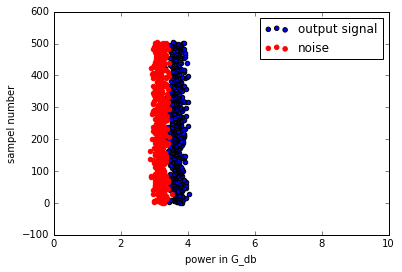

In [122]:
snr_s_10,  snr_n_10 = plt_snr(-5,500)
plot_snr_syn(snr_s_10, snr_n_10)
plt.xlim(0,10)

## SNR of test case 2 is -7dB 

(0, 10)

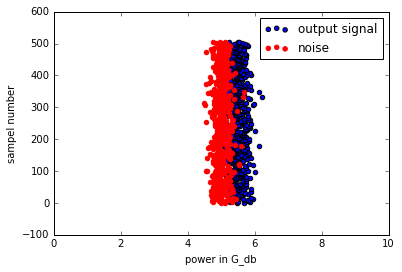

In [123]:
snr_s_10,  snr_n_10 = plt_snr(-7,500)
plot_snr_syn(snr_s_10, snr_n_10)
plt.xlim(0,10)

## SNR of test case 2 is -9dB 

(0, 10)

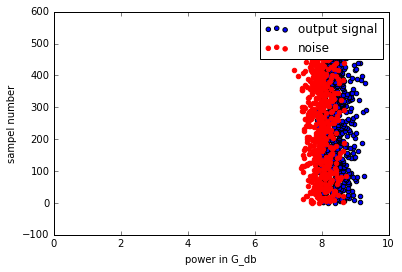

In [124]:
snr_s_10,  snr_n_10 = plt_snr(-9,500)
plot_snr_syn(snr_s_10, snr_n_10)
plt.xlim(0,10)

## Need to retweak classifier since prediction is awful
##  the idea is the predictive accuracy of the classifier goes down as the snr goes up
## eventually will plot accuracy vs snr

In [125]:
# Based on Professor Sundeep's Lab 7: SVM classifiers  

# Create training set and test set --> comprised of 500 samples where snr =4 and snr = -10
#X=np.empty(500)


#### ====> WORKING HERE
#snr_s_3,  snr_n_3 = synth_sP_nP(3,500)

X = np.array(snr_s_10[:125] + snr_s_3[:125] + snr_n_3[:125] + snr_n_10[:125])
y=np.concatenate([np.ones(125),np.ones(125),np.zeros(125),np.zeros(125)])
from sklearn import svm
svc = svm.SVC(probability=False,  kernel="rbf", C=2.8, gamma=.0073,verbose=10)

ntr = 400
nts = 100

Iperm = np.random.permutation(500)
Xtr = X[Iperm[:ntr]].reshape(-1,1)
ytr = y[Iperm[:ntr]].reshape(-1,1)
Xts = X[Iperm[ntr:ntr+nts]].reshape(-1,1)
yts = y[Iperm[ntr:ntr+nts]].reshape(-1,1)

svc.fit(Xtr,ytr)
# plot accuracy vs SNR

# predict accuracy
yhat1 = svc.predict(Xts)
acc = np.mean(yhat1 == yts)
print('Accuaracy = {0:f}'.format(acc))

[LibSVM]Accuaracy = 0.420000


/home/adi/.virtualenvs/scraper/lib/python3.4/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [126]:
####### PERSONAL NOTES #############
# signal and noise 
# get snr
# create picture from 
# recreate picture to show energy dectetion doesn't always  work


# ML -- > samples from when user is on channel: output 
# no user plain noise --> 
 # show as snr goes down
    
# generate these values

#bunch of red blue; plot; find if linearly sepearble
# #see what happens as snr decreases; becomes harder and harder to 

# M2M4

#energy detection method with threshold for each 
# modulating by carrier means mult by sin,cos
